## 🚦 Traffic Light Detection | Tensorflow

In [22]:
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from tqdm import tqdm
from dataclasses import dataclass

📦 Data Set:
 - LISA Traffic Light Dataset - 🚀
 - It has more than 44 minutes of annotated traffic light data.

## 1. Load Data

In [4]:
@dataclass
class AllPath:
    """Class for keeping track of an item in inventory."""
    _DATA_BASE_DIR:pathlib.Path = pathlib.Path('dataset')
    _DATA_ANOTATIONs:pathlib.Path  = _DATA_BASE_DIR / 'Annotations' / 'Annotations'
    DATA_ANOTATIONs_DAY_TRAIN:pathlib.Path = _DATA_ANOTATIONs / 'dayTrain'
    DATA_ANOTATIONs_NIGHT_TRAIN:pathlib.Path = _DATA_ANOTATIONs / 'nightTrain'

all_paths = AllPath()
all_paths

AllPath(_DATA_BASE_DIR=WindowsPath('dataset'), _DATA_ANOTATIONs=WindowsPath('dataset/Annotations/Annotations'), DATA_ANOTATIONs_DAY_TRAIN=WindowsPath('dataset/Annotations/Annotations/dayTrain'), DATA_ANOTATIONs_NIGHT_TRAIN=WindowsPath('dataset/Annotations/Annotations/nightTrain'))

In [5]:
day_train = []
night_train = []

for clip in tqdm(all_paths.DATA_ANOTATIONs_DAY_TRAIN.glob('*/')):
    df = pd.read_csv(pathlib.Path(clip) / 'frameAnnotationsBOX.csv', sep=';')
    day_train.append(df)


for clip in tqdm(all_paths.DATA_ANOTATIONs_NIGHT_TRAIN.glob('*/')):
    df = pd.read_csv(pathlib.Path(clip) / 'frameAnnotationsBOX.csv', sep=';')
    night_train.append(df)

df_day_train = pd.concat(day_train)
df_day_train['isNight'] = 0


df_night_train = pd.concat(night_train)
df_night_train['isNight'] = 1

df = pd.concat([df_day_train,df_night_train])
print('All day and Night training data shap:',df.shape)
df.head()

13it [00:00, 134.00it/s]
5it [00:00, 135.11it/s]

All day and Night training data shap: (51826, 11)


,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin file,Origin frame number,Origin track,Origin track frame number,isNight
0,dayTraining/dayClip1--00000.jpg,go,698,333,710,358,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0
1,dayTraining/dayClip1--00000.jpg,go,846,391,858,411,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0
2,dayTraining/dayClip1--00001.jpg,go,698,337,710,357,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0
3,dayTraining/dayClip1--00001.jpg,go,847,390,859,410,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0
4,dayTraining/dayClip1--00002.jpg,go,698,331,710,356,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,0


## 2. Preprocessing

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51826 entries, 0 to 3235
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Filename                   51826 non-null  object
 1   Annotation tag             51826 non-null  object
 2   Upper left corner X        51826 non-null  int64 
 3   Upper left corner Y        51826 non-null  int64 
 4   Lower right corner X       51826 non-null  int64 
 5   Lower right corner Y       51826 non-null  int64 
 6   Origin file                51826 non-null  object
 7   Origin frame number        51826 non-null  int64 
 8   Origin track               51826 non-null  object
 9   Origin track frame number  51826 non-null  int64 
 10  isNight                    51826 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 4.7+ MB


In [7]:
# drop duplicate columns
df = (
    df
    .T # transpose 
    .drop_duplicates() # drop duplicate rows
    .T # transpose back again
    )
df

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin file,Origin frame number,isNight
0,dayTraining/dayClip1--00000.jpg,go,698,333,710,358,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0
1,dayTraining/dayClip1--00000.jpg,go,846,391,858,411,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0
2,dayTraining/dayClip1--00001.jpg,go,698,337,710,357,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0
3,dayTraining/dayClip1--00001.jpg,go,847,390,859,410,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0
4,dayTraining/dayClip1--00002.jpg,go,698,331,710,356,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,0
...,...,...,...,...,...,...,...,...,...
3231,nightTraining/nightClip5--01450.jpg,go,937,221,976,290,nightTraining/nightClip5/clip5.mp4,1450,1
3232,nightTraining/nightClip5--01451.jpg,go,467,36,512,117,nightTraining/nightClip5/clip5.mp4,1451,1
3233,nightTraining/nightClip5--01451.jpg,go,937,219,976,288,nightTraining/nightClip5/clip5.mp4,1451,1
3234,nightTraining/nightClip5--01452.jpg,go,460,33,506,114,nightTraining/nightClip5/clip5.mp4,1452,1


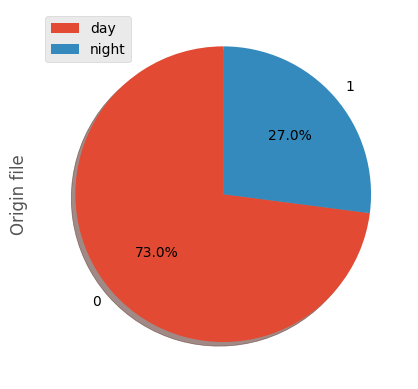

In [27]:
(
    df
    .groupby(by='isNight')
    .count()
    ['Origin file']
    .plot.pie(autopct='%1.1f%%',shadow=True,startangle=90)
)
plt.legend(['day', 'night'])